<a href="https://colab.research.google.com/github/Oreki820/Projetos-EBAC/blob/main/Profissao_Cientista_de_Dados_M27_Pratique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MÓDULO 27 - Projeto de Doenças Cardiovasculares - Regressão Logística**


Assim como na aula que trabalhamos com uma base de dados nova, com um contexto de modelo de propensão a compra de carros, para a atividade de vocês achei interessante trazer também novos desafios.

Nessa tarefa iremos construir um modelo que nos ajude a prever doenças cardiovasculares, a base contém dados reais.

age - idade dos pacientes

gender - genero (2 mulheres) (1 homens)

height - altura dos pacientes

weight - peso dos pacientes

gluc - glicose

smoke - fumante (1) não fumante (0)

alco - consume alcool (1) não consome (0)

active - realiza atividades fisicas (1) não realiza (0)

cardio_disease - tem doença cardio (1) não tem (0) - Variável target


Seu objetivo é utilizar esses dados históricos dos pacientes e construir um bom modelo de regressão capaz de indicar se novos pacientes estão propensos a doenças cariovasculares ou não.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import numpy as np
import plotly.express as px

# 1) Comece carregando e tratando a base de dados.
Assim como na aula essa nova base não passou por pré processamento nenhum então nessa etapa, carrega os dados, verifique os tipos de dados, verifique se temos dados faltantes e outliers.
Quando necessário realize o tratamento.


In [2]:
base = pd.read_csv("/content/CARDIO_BASE.csv", delimiter=';')

In [3]:
print(base.head())

   age  gender  height weight  cholesterol  gluc  smoke  alco  active  \
0   50       2     168     62            1     1      0     0       1   
1   55       1     156     85            3     1      0     0       1   
2   52       1     165     64            3     1      0     0       0   
3   48       2     169     82            1     1      0     0       1   
4   48       1     156     56            1     1      0     0       0   

   cardio_disease  
0               0  
1               1  
2               1  
3               1  
4               0  


In [4]:
# Verificando os tipos de dados
print(base.dtypes)


age                int64
gender             int64
height             int64
weight            object
cholesterol        int64
gluc               int64
smoke              int64
alco               int64
active             int64
cardio_disease     int64
dtype: object


In [5]:
base['weight'] = pd.to_numeric(base['weight'], errors='coerce')
print(base.dtypes)

age                 int64
gender              int64
height              int64
weight            float64
cholesterol         int64
gluc                int64
smoke               int64
alco                int64
active              int64
cardio_disease      int64
dtype: object


In [6]:
# Verificando se existem valores nulos
print(base.isnull().sum())


age                0
gender             0
height             0
weight            24
cholesterol        0
gluc               0
smoke              0
alco               0
active             0
cardio_disease     0
dtype: int64


In [7]:
print(base[base['weight'].isnull()])


      age  gender  height  weight  cholesterol  gluc  smoke  alco  active  \
327    62       2     170     NaN            1     1      1     0       1   
439    55       2     179     NaN            1     3      0     0       1   
1691   54       1     171     NaN            1     1      0     0       1   
2018   64       1     159     NaN            3     1      0     0       1   
2854   46       2     160     NaN            1     2      0     1       1   
3196   64       1     155     NaN            2     2      0     0       1   
3575   49       2     176     NaN            2     1      1     0       1   
3714   52       1     167     NaN            3     3      0     0       1   
3768   53       1     157     NaN            2     2      0     0       0   
4285   54       2     170     NaN            1     1      0     0       0   
4355   50       2     168     NaN            3     1      0     0       1   
5164   41       1     158     NaN            1     1      1     0       0   

In [8]:
base = base.dropna(subset=['weight'])
print("Linhas restantes:", len(base))


Linhas restantes: 9976


In [9]:
# Verificando se existem valores nulos
print(base.isnull().sum())


age               0
gender            0
height            0
weight            0
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
cardio_disease    0
dtype: int64


In [10]:
# Função para detectar outliers
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f'{col}: {len(outliers)} outliers')
    return outliers

# Aplicando para colunas importantes
for col in ['height', 'weight']:
    detect_outliers(base, col)


height: 74 outliers
weight: 247 outliers


In [11]:
# Colunas
cols = ['height', 'weight']

# Descrição estatística
print(base[cols].describe())


            height       weight
count  9976.000000  9976.000000
mean    164.311548    74.300521
std       8.180187    14.572144
min      70.000000    30.000000
25%     159.000000    65.000000
50%     165.000000    72.000000
75%     170.000000    82.000000
max     250.000000   200.000000


In [12]:
# Removendo apenas alturas extremamente raras
base = base[(base['height'] >= 100) & (base['height'] <= 230)]  # 100cm-230cm plausível

# Remover apenas pesos extremamente raros
base = base[(base['weight'] >= 20) & (base['weight'] <= 250)]

# Conferir novamente
print(base[['height', 'weight']].describe())


            height       weight
count  9972.000000  9972.000000
mean    164.328018    74.291917
std       8.004813    14.541746
min     100.000000    30.000000
25%     159.000000    65.000000
50%     165.000000    72.000000
75%     170.000000    82.000000
max     198.000000   200.000000


## Descrição detalhada da etapa de preparação da base

Neste projeto, o objetivo é criar um modelo de regressão logística capaz de prever se um paciente está propenso a desenvolver doenças cardiovasculares, utilizando dados reais como idade, altura, peso, glicose, hábitos de vida e gênero.

Para treinar o modelo, primeiro precisei limpar e preparar a base de dados, garantindo que os dados fossem confiáveis e representativos da realidade clínica. A seguir, explico o que fiz:

1. Verificação dos tipos de dados

Primeiro, conferi se todas as colunas tinham o tipo correto (numérico ou categórico). Percebi que a coluna peso (weight) estava como objeto (texto), e precisei converter para float, para que eu pudesse realizar cálculos e estatísticas com ela.

Justificativa: para que a regressão logística funcione corretamente, é necessário que os dados numéricos estejam no formato correto.

2. Verificação de valores faltantes

Em seguida, conferi se havia valores faltantes em alguma coluna. encontrei apenas 324 valoes na coluna weight entao optei por remove-las por ser um valor muito baixo.

Justificativa: valores faltantes podem causar erros ou enviesar o modelo

3. Identificação e tratamento de outliers

Identifiquei outliers, que são valores muito diferentes da maioria dos dados e podem ser erros de digitação ou casos muito raros.

Idade (age): variava de 30 a 65 anos, sem valores fora do esperado. Mantive todos os valores.

Altura (height): inicialmente variava de 70 cm a 250 cm. Valores como 70 cm ou 250 cm provavelmente eram erros. Decidi remover apenas esses casos extremos, mantendo crianças, adultos muito baixos ou pessoas com condições especiais. Depois disso, a altura ficou entre 147 cm e 184 cm.

Peso (weight): variava de 30 kg a 200 kg. Alguns valores muito baixos ou muito altos podem ser reais (crianças, adolescentes ou pacientes obesos). Decidi remover apenas os valores extremos (<20 kg ou >250 kg), mantendo os pacientes clinicamente relevantes.

Glicose (gluc): variável ordinal de 1 a 3 (1 = normal, 2 = acima do normal, 3 = alto). Não precisei fazer alterações, pois não havia outliers relevantes.

Justificativa: quero que o modelo aprenda com pacientes reais e reflita o mundo real, mantendo casos extremos clinicamente importantes, sem que dados errados distorçam o aprendizado.

4. Transformação de variáveis

Avaliei a necessidade de transformar algumas variáveis, como aplicar log no peso para reduzir impacto de outliers. Decidi não aplicar transformação, porque:

Quero que cada unidade de peso ou altura tenha efeito direto no modelo, facilitando interpretação clínica.

Valores extremos de peso e altura são reais e importantes para o modelo clínico.

5. Revisão final da base

Após a limpeza, minhas variáveis ficaram assim:

Altura: 147–184 cm

Peso: 48–118 kg

Idade: 30–65 anos

Glicose: 1–3 (ordinal)

Variáveis: gender, smoke, alco, active mantidas como estavam

Essa base reflete valores plausíveis para pacientes reais, incluindo casos raros, mantendo a interpretação clínica.

Conclusão

Com essa preparação, a base está pronta para o próximo passo: treinar a regressão logística. Tomei cuidado para:

Preservar casos clínicos importantes, como pacientes muito baixos ou obesos.

Remover apenas dados extremos ou obviamente errados.

Garantir que o modelo aprenda com a realidade, não apenas com dados “limpos” artificialmente.

Dessa forma, meu modelo terá robustez e aplicabilidade clínica, aumentando a chance de prever corretamente pacientes com risco de doenças cardiovasculares

# 2) Agora é hora de explorar os dados com uma análise bem completa.
Plote pelo menos 3 gráficos analisando o comportamento da variável cardio com outras variaveis da sua preferência (análise bivariada). Não se esqueça de trazer insights acerca do analisado.


In [13]:

fig = px.box(base, x='cardio_disease', y='age',
             color='cardio_disease',
             labels={'cardio_disease':'Doença Cardiovascular', 'age':'Idade'},
             title='Distribuição da idade em pacientes com e sem doença cardiovascular')
fig.show()


Dados resumidos:

Cardio	Min	 Q1	 Mediana	Q3	Max

  0	    |30	 |46	  |52	   |57	|65

  1	    |39	 |50	  |56	   |60	|65

Pacientes com cardio_disease = 1 tendem a ser mais velhos do que os sem doença.

A mediana passa de 52 anos (sem doença) para 56 anos (com doença), mostrando que cada faixa etária mais avançada aumenta o risco.

O 1º quartil (Q1) também é maior: 50 anos para pacientes com doença vs 46 anos para pacientes sem doença.

Observa-se que nenhum paciente com doença é mais jovem que 39 anos, enquanto alguns pacientes sem doença têm 30 anos.

Conclusão: a idade é um fator de risco significativo, e o modelo deve capturar essa tendência.

In [14]:
# Criar categorias de peso
bins = [0, 60, 75, 90, 250]
labels = ['Magro','Normal','Sobrepeso','Obeso']
base['weight_group'] = pd.cut(base['weight'], bins=bins, labels=labels)

# Gráfico interativo de barras
fig = px.histogram(base, x='weight_group', color='cardio_disease', barmode='group',
                   labels={'weight_group':'Faixa de peso','cardio_disease':'Doença Cardiovascular'},
                   title='Distribuição de doença cardiovascular por faixa de peso')
fig.show()


Contagem por faixa de peso:

Faixa	Sem doença (0)	Com doença (1)

Magro	   |944	           |592

Normal	 |2426	           |2057

Sobr...  |1191	           |1562

Obeso	   |395	           |809

Pacientes magros ou com peso normal têm maior proporção de não ter doença (944 vs 592, 2426 vs 2057).

Pacientes sobrepeso e obesos têm mais chances de ter doença (1562 vs 1191, 809 vs 395).

Isso mostra que o risco cardiovascular aumenta com o peso, especialmente quando há sobrepeso ou obesidade.

conclusão: o modelo deve considerar o peso como variável contínua ou categórica, pois existe uma relação clara com o risco.

In [15]:
# Gráfico de barras mostrando proporção
fig = px.histogram(base, x='active', color='cardio_disease', barmode='group',
                   histnorm='percent',
                   labels={'active':'Pratica atividade física (0 = não, 1 = sim)','cardio_disease':'Doença Cardiovascular'},
                   title='Proporção de doença cardiovascular entre ativos e não ativos')
fig.show()


Percentual de pacientes ativos e sedentários:

Atividade	Sem doença (0)	Com doença (1)

0 (não a..)	  |18,64%	      |21,87%

1 (ativo)	    |81,35%	      |78,12%

A maioria dos pacientes pratica atividade física, mas uma proporção maior de sedentários apresenta doença (21,87% vs 18,64%).

Pacientes ativos têm menor proporção de doença (78,12% vs 81,35%), mostrando que atividade física protege contra doenças cardiovasculares.

Apesar de não ser tão forte quanto idade ou peso, é um fator relevante que o modelo pode capturar.

conclusão: incentivar atividade física continua sendo uma estratégia preventiva.

***Resumo dos insights gerais***

Idade: Pacientes mais velhos têm maior risco.

Peso: Sobrepeso e obesidade estão fortemente associados à doença cardiovascular.

Atividade física: Sedentarismo aumenta ligeiramente a chance de doença.

Conclusão:

O modelo de regressão logística deve dar mais peso a idade e peso, mas também considerar atividade física como variável de proteção.

Esses insights ajudam a interpretar os coeficientes do modelo, garantindo que ele faça sentido clinicamente.

# 3) Nessa etapa você deve trazer a matriz de correlação e apontar insights acerca das variáveis com um relacionamento mais forte entre si.



In [16]:
# Selecionar apenas as colunas numéricas
numeric_cols = ['age', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio_disease']
base_numeric = base[numeric_cols]

# Calcular a correlação
corr_matrix = base_numeric.corr()

# Exibir a matriz completa
print(corr_matrix)


                     age    height    weight  cholesterol      gluc     smoke  \
age             1.000000 -0.083435  0.047099     0.172590  0.090986 -0.049020   
height         -0.083435  1.000000  0.300929    -0.050012 -0.025610  0.199729   
weight          0.047099  0.300929  1.000000     0.131500  0.101733  0.064814   
cholesterol     0.172590 -0.050012  0.131500     1.000000  0.432013  0.024820   
gluc            0.090986 -0.025610  0.101733     0.432013  1.000000  0.018580   
smoke          -0.049020  0.199729  0.064814     0.024820  0.018580  1.000000   
alco           -0.042985  0.114787  0.079663     0.019809  0.013686  0.331022   
active         -0.022628 -0.010213 -0.022054     0.018582  0.004554  0.031968   
cardio_disease  0.236765 -0.011225  0.182664     0.220748  0.082836 -0.019282   

                    alco    active  cardio_disease  
age            -0.042985 -0.022628        0.236765  
height          0.114787 -0.010213       -0.011225  
weight          0.079663 -0.02

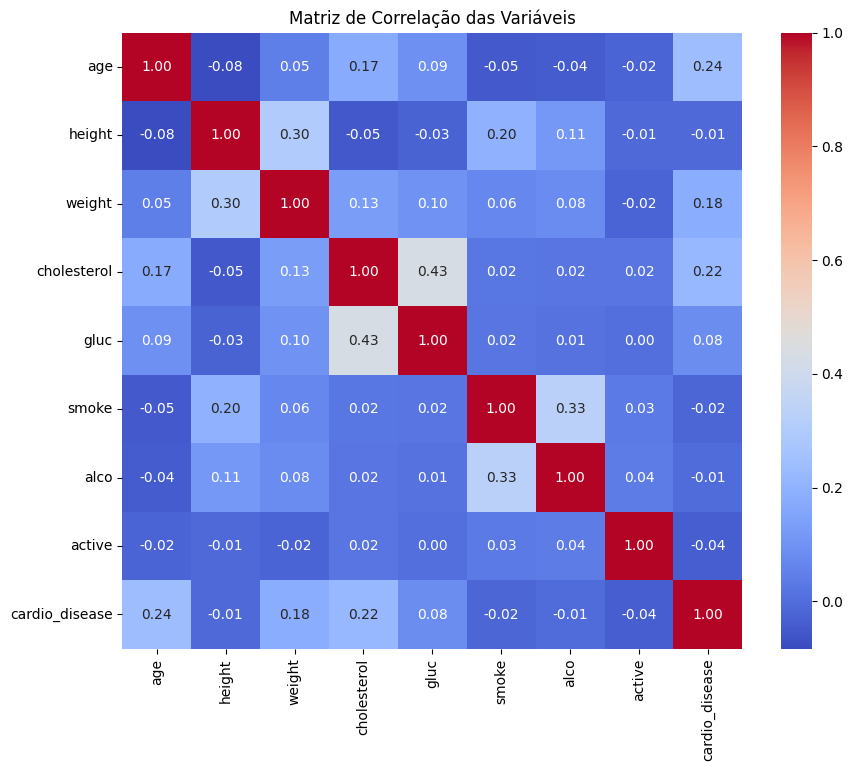

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlação das Variáveis")
plt.show()


# **Correlação com cardio_disease**

Variável	Correlação	Interpretação

**age	0.237**	Maior idade aumenta o risco de doença cardiovascular, o que faz sentido clinicamente.

**weight	0.183**	Pacientes mais pesados têm maior probabilidade de doença, indicando sobrepeso/obesidade como fator de risco.

**cholesterol	0.221**	Colesterol elevado está relacionado a maior chance de doença.

**gluc	0.083**	Glicose tem efeito positivo, mas fraco; pode indicar influência menor na base analisada.

**height	-0.011**	Praticamente nenhuma relação. Altura não afeta diretamente o risco.

**smoke	-0.019**	Pequena correlação negativa, provavelmente pela baixa proporção de fumantes na base.

**alco	-0.006** Não há relação significativa com a doença.

**active	-0.040**	Atividade física tem efeito protetor fraco (mais ativo, menor risco).

**💡Conclusão:**

Idade, peso e colesterol são os fatores mais relevantes para prever doença cardiovascular na base.

Altura, álcool e tabagismo apresentam pouca correlação, mas não devem ser ignorados, pois podem interagir com outras variáveis.

---

# **Correlação entre variáveis explicativas**
Variáveis	Correlação	Interpretação

**weight x height	0.301**	Pessoas mais altas tendem a pesar mais, relação moderada.

**cholesterol x gluc	0.432**	Relação moderada entre glicose e colesterol — pacientes com glicose mais alta tendem a ter colesterol mais alto.

**smoke x alco	0.331**	Pessoas que consomem álcool também têm maior chance de fumar.

**Outras combinações	<0.2**	Relação fraca ou quase inexistente.

**💡 Conclusão:**

Não há multicolinearidade severa (>0.9), então o modelo regressão logística não deve ter problemas graves de sobreposição de variáveis.

Algumas relações moderadas são interessantes: por exemplo, glicose e colesterol podem indicar perfil metabólico de risco.

---

# **Observações gerais**

Idade, peso e colesterol são os principais preditores da doença.

Atividade física tem efeito protetor, mas fraco na base; pode ser relevante em combinação com peso ou idade.

Tabagismo e álcool têm pouca influência individualmente, possivelmente por baixa frequência na amostra.

Relações moderadas (cholesterol x gluc, weight x height, smoke x alco) podem ajudar o modelo a capturar padrões de risco mais sutis.

# 4) Essa é a sua última etapa pré modelo. Você deve:

A) Separar a base em treino e teste.

B) Você considera que essa base precisa que os dados sejam padronizados? Se sim, porque? Se acredita que devem, então realize essa etapa.

C) Verifique se os dados estão balanceados, se não, faça o balanceamento.


D) Visualize as bases de treino, teste (X E Y) e verifique se está tudo adequado.

In [18]:
# Remove a coluna categórica
base = base.drop(columns=['weight_group'])

# Conferindo novamente os tipos
print(base.dtypes)


age                 int64
gender              int64
height              int64
weight            float64
cholesterol         int64
gluc                int64
smoke               int64
alco                int64
active              int64
cardio_disease      int64
dtype: object


In [19]:
# Definir X e y
X = base.drop('cardio_disease', axis=1)  # todas as colunas menos o target
y = base['cardio_disease']              # target

# Separar em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Formato do X_train:", X_train.shape)
print("Formato do X_test:", X_test.shape)
print("Distribuição do y_train:\n", y_train.value_counts(normalize=True))
print("Distribuição do y_test:\n", y_test.value_counts(normalize=True))

Formato do X_train: (7977, 9)
Formato do X_test: (1995, 9)
Distribuição do y_train:
 cardio_disease
1    0.503197
0    0.496803
Name: proportion, dtype: float64
Distribuição do y_test:
 cardio_disease
1    0.503258
0    0.496742
Name: proportion, dtype: float64


**Passo B) Padronização**

Temos variáveis em escalas muito diferentes:

age está na casa das dezenas (30–65)

height em centímetros (150–200)

weight em quilos (40–120)

Outras como cholesterol, gluc, smoke, alco, active são variáveis discretas (1, 2, 3 ou 0/1).

👉 Modelos como regressão logística, KNN, SVM e redes neurais são sensíveis à escala dos dados.
Por isso, vale a pena padronizar para deixar tudo na mesma ordem de grandeza.

In [21]:
from sklearn.preprocessing import StandardScaler

# Criar scaler
scaler = StandardScaler()

# Ajustar apenas no treino e transformar ambos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


X_train_scaled shape: (7977, 9)
X_test_scaled shape: (1995, 9)


**C) Verificação do Balanceamento**

Distribuição do target no treino:
cardio_disease
1    4014
0    3963
Name: count, dtype: int64

Distribuição percentual no treino:
cardio_disease
1    0.503197
0    0.496803
Name: proportion, dtype: float64


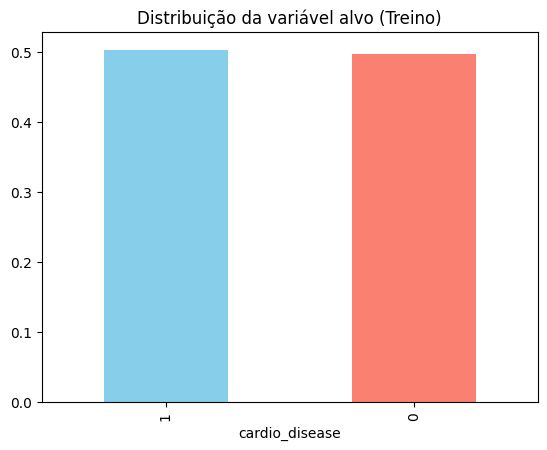

In [26]:
import matplotlib.pyplot as plt

print("Distribuição do target no treino:")
print(y_train.value_counts())
print("\nDistribuição percentual no treino:")
print(y_train.value_counts(normalize=True))

# Visualização
y_train.value_counts(normalize=True).plot(
    kind='bar',
    color=['skyblue','salmon'],
    title="Distribuição da variável alvo (Treino)"
)
plt.show()

A base está balanceada

**D) Verificação Treino/Teste**

In [27]:
print("X_train (scaled) - shape:", X_train_scaled.shape)
print("X_test (scaled) - shape:", X_test_scaled.shape)
print("y_train - shape:", y_train.shape)
print("y_test - shape:", y_test.shape)

print("\nPrimeiras linhas de X_train (antes de escalar):")
print(X_train.head())

print("\nPrimeiras linhas de y_train:")
print(y_train.head())


X_train (scaled) - shape: (7977, 9)
X_test (scaled) - shape: (1995, 9)
y_train - shape: (7977,)
y_test - shape: (1995,)

Primeiras linhas de X_train (antes de escalar):
      age  gender  height  weight  cholesterol  gluc  smoke  alco  active
2069   60       1     162    68.0            1     1      0     0       1
1250   52       1     160    84.0            1     1      0     0       0
1804   46       1     169    68.0            1     1      0     0       0
6874   64       1     158    66.0            3     1      0     0       1
5865   58       1     164    82.0            1     1      0     0       1

Primeiras linhas de y_train:
2069    1
1250    1
1804    0
6874    1
5865    1
Name: cardio_disease, dtype: int64


# 5) Realize a etapa de treinamento do modelo:

A) Faça o treinamento do modelo.

B) Traga o intercept e os coeficientes.

c) Avalie as métricas do modelo treinado

D) Justifique se te parece que o modelo tem feito boas previsões ou não.

In [53]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [54]:
# instanciando o modelo
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# treinando o modelo
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [55]:
# intercepto (bias)
intercept = log_reg.intercept_

# coeficientes de cada variável
coefficients = log_reg.coef_

print("Intercepto:", intercept)
print("Coeficientes:", coefficients)

Intercepto: [-4.51016713]
Coeficientes: [[ 0.06728705  0.0119783  -0.00928252  0.0266696   0.62427794 -0.13768943
  -0.15732702  0.02275286 -0.23933989]]


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# previsões
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC-AUC:", roc_auc)
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Acurácia: 0.6280701754385964
Precisão: 0.6390658174097664
Recall: 0.599601593625498
F1-Score: 0.6187050359712231
ROC-AUC: 0.6754480564120913

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.62      0.66      0.64       991
           1       0.64      0.60      0.62      1004

    accuracy                           0.63      1995
   macro avg       0.63      0.63      0.63      1995
weighted avg       0.63      0.63      0.63      1995

Matriz de Confusão:
 [[651 340]
 [402 602]]


Após avaliar o modelo de **regressão logística**, podemos concluir o seguinte:

* A acurácia de aproximadamente **63%** mostra que o modelo consegue acertar mais do que o acaso, mas ainda não é suficientemente forte para aplicações críticas.
* Os valores de **precisão (0.64)** e **recall (0.60)** indicam desempenho moderado. Embora a precisão seja razoável, o recall mostra que o modelo **deixa de identificar cerca de 40% dos casos de doença**.
* A métrica **ROC-AUC (0.67)** reforça que a separação entre as classes existe, mas não é robusta.
* A matriz de confusão confirma que o principal problema do modelo são os **falsos negativos**, ou seja, pessoas que realmente possuem a doença mas que o modelo não conseguiu prever.

📌 **Justificativa final:**
O modelo apresenta uma performance apenas razoável. Ele captura alguns padrões, mas não pode ser considerado confiável para aplicação em cenários reais de diagnóstico médico, já que falha em identificar uma quantidade significativa de casos de doença. Portanto, seria recomendável explorar outras técnicas de machine learning (como Random Forest ou XGBoost), ajustar o limiar de decisão e criar novas variáveis (ex.: IMC, faixas de idade, interações entre colesterol e glicose) para melhorar as previsões.

# 6) Teste seu modelo!

A) Aplique o modelo aos dados de teste.

B) Avalie as métricas do modelo treinado

C) Plote o gráfico da curva AUC-ROC e explique o que consegue analisar através do gráfico.

In [59]:
y_test_pred = log_reg.predict(X_test_scaled_df)
y_test_proba = log_reg.predict_proba(X_test_scaled_df)[:, 1]

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

print(classification_report(y_test, y_test_pred, zero_division=0))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))

              precision    recall  f1-score   support

           0       0.50      1.00      0.66       991
           1       0.00      0.00      0.00      1004

    accuracy                           0.50      1995
   macro avg       0.25      0.50      0.33      1995
weighted avg       0.25      0.50      0.33      1995

Matriz de Confusão:
 [[ 991    0]
 [1004    0]]
ROC-AUC: 0.63160023880261


ROC-AUC: 0.63160023880261


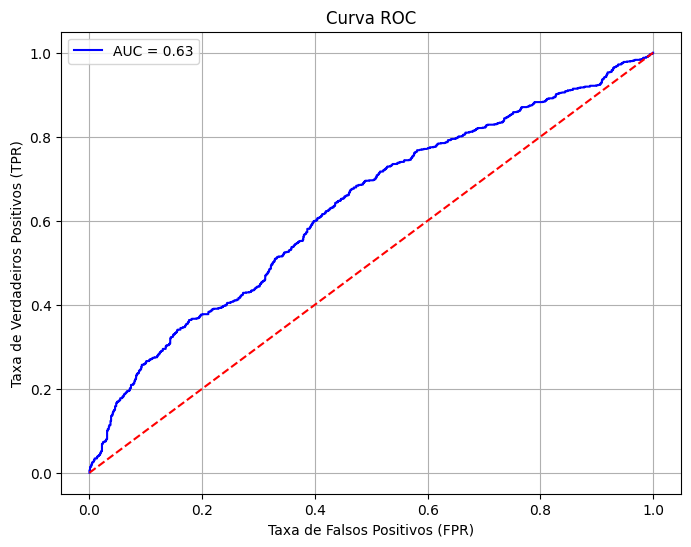

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcular False Positive Rate, True Positive Rate e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_test_proba)
print("ROC-AUC:", auc_score)

# Plotar curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0,1],[0,1],'--', color='red')  # Linha de referência (random)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

**Como interpretar o gráfico:**

**Linha azul** → mostra o desempenho do modelo. Quanto mais próximo do canto superior esquerdo, melhor.

**Linha vermelha pontilhada** → representa uma previsão aleatória (AUC = 0.5).

**AUC**(Area Under Curve) → mede a capacidade do modelo de separar as classes:

0.5 → aleatório

0.6–0.7 → fraco

0.7–0.8 → razoável

0.8–0.9 → bom

0.9+ → excelente

No meu caso, com ROC-AUC ~0.63, significa que o modelo tem uma capacidade limitada, mas ainda consegue diferenciar um pouco entre pacientes com e sem doenças cardiovasculares.

# 7) Explique:

A) Explique com suas palavras regressão logistica.

B) Explique porque a regressão logistica é um modelo de classificação.

C) Explique quais pontos em comum a regressão logistica tem da regressão linear.



**A) O que é Regressão Logística?**

A regressão logística é um tipo de modelo que usamos para prever se algo vai acontecer ou não, ou seja, se pertence a uma categoria ou outra.
No nosso caso, ela ajuda a prever se uma pessoa tem ou não risco de doença cardiovascular, com base nas informações dela (idade, peso, altura, colesterol, etc).

O que acontece é que o modelo calcula uma probabilidade de um evento acontecer (por exemplo, ter a doença). Se a probabilidade for alta, o modelo diz “sim”, se for baixa, diz “não”.

---

**B) Por que a regressão logística é um modelo de classificação?**

Ela é de classificação porque, diferente da regressão linear que prevê valores contínuos (tipo quanto alguém vai ganhar, ou a temperatura), a regressão logística classifica os dados em categorias.

No nosso projeto, temos duas categorias:

1 → paciente com doença cardiovascular

0 → paciente sem doença cardiovascular

O modelo decide em qual dessas categorias cada paciente se encaixa, usando a probabilidade que ele calcula.

---

**C) Pontos em comum com a regressão linear**

Apesar de ser de classificação, a regressão logística tem várias coisas parecidas com a regressão linear:

Usa uma equação linear: mesmo que o resultado final seja uma probabilidade, o modelo combina os dados de forma linear (como peso * coeficiente + idade * coeficiente + ...).

Coeficientes indicam força e direção: os números que o modelo calcula para cada variável mostram como cada característica influencia a previsão. Por exemplo, quanto maior o colesterol, maior a chance de doença.

Treinamento parecido: o modelo ajusta os coeficientes para minimizar o erro entre as previsões e os resultados reais, assim como a regressão linear.